In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()
sc = spark.sparkContext

# A JSON dataset is pointed to by path.
# The path can be either a single text file or a directory storing text files


21/09/20 18:23:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
path = "wallets_test"
# path = "wallets"
wallets_df = spark.read.json(path)

wallets = wallets_df.rdd.map(lambda w:    w.asDict(True)  ) 


In [4]:
wallet_transactions = wallets.flatMap(lambda w:  [ (w['address'], tx) for tx in w['txs'] or [] ] ) \
                                .map(lambda w:  (w[0], (w[1].get('incoming' ), w[1].get('outgoing' ))  ))


balance = wallets.map(lambda w: (w['address'], float(w['balance'])  ))
received_value = wallets.map(lambda w: (w['address'], float(w['received_value'])  ))
total_txs = wallets.map(lambda w: (w['address'], float(w['total_txs'])  ))
txs_in =  wallet_transactions.mapValues(lambda w:   w[0]  ).filter(lambda w: w[1] is not None)
txs_out = wallet_transactions.mapValues(lambda w:   w[1]  ).filter(lambda w: w[1] is not None)

a_in = txs_in.flatMapValues(lambda tx: tx.get('inputs',[])).mapValues(lambda tx: tx['address'] )
a_out = txs_out.flatMapValues(lambda tx: tx.get('outputs',[])).mapValues(lambda tx: tx['address'] )

v_in = txs_in.mapValues(lambda w:    float(w.get('value', 0)) )
v_out = txs_out.mapValues(lambda w:   float(w.get('value', 0)) )

# features

avg_vin = v_in.mapValues(lambda v: (v,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])
avg_vout =  v_out.mapValues(lambda v: (v,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])

var_vin = v_in.join(avg_vin).mapValues(lambda v: ((v[0]-v[1])**2,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])
var_vout =  v_out.join(avg_vout).mapValues(lambda v: ((v[0]-v[1])**2,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])

unique_deg_in = a_in.mapValues( lambda x: {x}).reduceByKey((lambda a, b: a.union(b))).mapValues(len)
unique_deg_out = a_out.mapValues( lambda x: {x}).reduceByKey((lambda a, b: a.union(b))).mapValues(len)

deg_in = a_in.mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)
deg_out = a_out.mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)

# unique_deg_in.collect(), deg_in.collect()
v_in.first(), v_out.first()

(('1A6HyDLS5nVtoL4Vt8hYhPKyPFm1ZDWH5a', 0.01254508),
 ('1A6HyDLS5nVtoL4Vt8hYhPKyPFm1ZDWH5a', 0.0321144))

In [5]:
rdds = [ avg_vin, avg_vout, var_vin, var_vout, unique_deg_in, unique_deg_out, deg_in, deg_out, balance, received_value, total_txs]
names = [ 'avg_vin', 'avg_vout', 'var_vin', 'var_vout', 'unique_deg_in', 'unique_deg_out', 'deg_in', 'deg_out', 'balance', 'received_value', 'total_txs']



final_df = None
for  rdd, name in zip(rdds,names):
    df = rdd.toDF(['addr', name ])
    print(df)
    if final_df is None:
        final_df = df
    else:
        final_df = final_df.join(df,'addr', 'outer')



DataFrame[addr: string, avg_vin: double]
DataFrame[addr: string, avg_vout: double]


DataFrame[addr: string, var_vin: double]
DataFrame[addr: string, var_vout: double]
DataFrame[addr: string, unique_deg_in: bigint]
DataFrame[addr: string, unique_deg_out: bigint]
DataFrame[addr: string, deg_in: bigint]
DataFrame[addr: string, deg_out: bigint]
DataFrame[addr: string, balance: double]
DataFrame[addr: string, received_value: double]
DataFrame[addr: string, total_txs: double]


In [6]:

pandas_df = final_df.toPandas().fillna(0)
pandas_df


,addr,avg_vin,avg_vout,var_vin,var_vout,unique_deg_in,unique_deg_out,deg_in,deg_out,balance,received_value,total_txs
0,1A7HLMwmERQbWPYnsCHv2Rg9QRPFy7wpXG,0.060408,0.067190,1.980847e-03,1.638763e-03,7,41.0,55,88.0,0.152927,334.842091,3288.0
1,1AMuZfAwjmUEStt8Jd19ZM1BLqWGT8fNb,0.014916,0.020588,2.506676e-04,3.593302e-04,36,22.0,61,44.0,0.002003,0.992379,87.0
2,1atFpweBezrV8jw26MBFKPJE8WmwSSPnh,0.000415,0.000000,0.000000e+00,0.000000e+00,1,0.0,1,0.0,0.000415,0.000415,1.0
3,1A6HyDLS5nVtoL4Vt8hYhPKyPFm1ZDWH5a,0.077364,0.117141,1.198766e-02,1.292248e-02,881,41.0,1055,43.0,0.028357,6.498035,61.0
4,1AjbRiByDPqxNAfVbbtt1YVrJSbFvoz6S9,0.022336,0.030276,3.541730e-04,6.973680e-04,23,3.0,25,23.0,0.008472,0.402055,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
176,1AMcx6uau88bUGKUPiBd3327ewPYdBmZ54,0.001036,0.000000,0.000000e+00,0.000000e+00,1,0.0,1,0.0,0.001036,0.001036,1.0
177,1AjhkuTMVBoBRAXBzMXR1bz9ptBSpYMeD,0.015000,0.000000,0.000000e+00,0.000000e+00,1,0.0,1,0.0,0.015000,0.015000,1.0
178,1AGdBrCsVJLXLBBVmAgqG77j6LnesE2gbG,0.003039,0.003039,0.000000e+00,0.000000e+00,2,2.0,2,2.0,0.000000,0.003039,1.0
179,1AR6AUZdcD7GRkCt3M3356dvPcs2VxMKai,0.002119,0.000000,0.000000e+00,0.000000e+00,3,0.0,3,0.0,0.002119,0.002119,1.0


In [11]:
pandas_df['addr'] = pandas_df['addr'].astype(str)

from database import *

pandas_df.to_sql('wallets_meta', engine,  if_exists='replace', index=False, )


### Machine Learning
Here there is code for PCA + KMeans

In [13]:
import sklearn.preprocessing
import pandas as pd




pandas_df = pd.read_sql_table('wallets_meta', engine)

data = pandas_df.loc[:, pandas_df.columns != 'addr'].to_numpy()
norm_data = sklearn.preprocessing.normalize(data)


In [14]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca = pca.fit(norm_data)
grid = pca.transform(norm_data)

In [ ]:

from sklearn.cluster import KMeans
kmeans = KMeans(3)
kmeans.fit(norm_data)
color_number = kmeans.predict(norm_data)

colors = [ ['r','g','b'][i] for i in color_number]
print(colors)


['b', 'g', 'r', 'r', 'g', 'r', 'r', 'g', 'g', 'r', 'g', 'g', 'g', 'r', 'r', 'r', 'g', 'r', 'g', 'r', 'g', 'g', 'r', 'g', 'b', 'g', 'b', 'b', 'r', 'r', 'g', 'g', 'b', 'g', 'g', 'g', 'b', 'r', 'g', 'g', 'b', 'r', 'g', 'g', 'g', 'b', 'g', 'g', 'r', 'b', 'r', 'g', 'b', 'r', 'b', 'r', 'g', 'b', 'b', 'g', 'g', 'b', 'r', 'b', 'g', 'r', 'r', 'g', 'r', 'b', 'b', 'b', 'g', 'r', 'b', 'r', 'b', 'g', 'g', 'b', 'r', 'r', 'g', 'g', 'r', 'r', 'r', 'g', 'g', 'g', 'r', 'b', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'b', 'r', 'g', 'g', 'r', 'b', 'b', 'r', 'g', 'g', 'g', 'g', 'r', 'b', 'b', 'r', 'b', 'r', 'r', 'g', 'r', 'g', 'g', 'r', 'r', 'b', 'b', 'g', 'b', 'r', 'g', 'r', 'r', 'b', 'g', 'g', 'r', 'r', 'r', 'g', 'g', 'r', 'g', 'r', 'g', 'b', 'g', 'g', 'r', 'r', 'r', 'r', 'b', 'b', 'g', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'g', 'g', 'g', 'b', 'r', 'b', 'b', 'r', 'g', 'r', 'g', 'r', 'r', 'g', 'g', 'r', 'r', 'g', 'r', 'g']


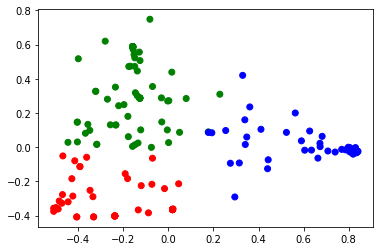

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(*grid.T, c=colors)